### Import Libraries

In [37]:
import pandas as pd
import numpy as np
import psycopg2
import os
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import requests
import zipfile
import shutil
from datetime import datetime, timedelta

### Downloading the data to be analyzed

In [3]:
conn = psycopg2.connect(
    host="zip_data_postgres_db",
    database=os.environ.get('POSTGRES_DB'),
    user=os.environ.get('POSTGRES_USER'),
    password=os.environ.get('POSTGRES_PASSWORD')
)

query = "SELECT * FROM reporting_results2020"
df = pd.read_sql_query(query, conn)

/tmp/ipykernel_393/2587181120.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


### Displaying a sample of downloaded data

In [4]:
df.head()

,id,numer_ewidencyjny_system,numer_ewidencyjny_urzad,data_wplywu_wniosku_do_urzedu,nazwa_organu,wojewodztwo_objekt,obiekt_kod_pocztowy,miasto,terc,cecha,...,kubatura,stan,jednostki_numer,obreb_numer,numer_dzialki,numer_arkusza_dzialki,nazwisko_projektanta,imie_projektanta,projektant_numer_uprawnien,projektant_pozostali
0,1,ST-SL-BI/ZGŁOSZENIE/1432/2020,Wb.6743.3.107.2020.KaM,2020-06-04 00:00:00,Starosta Powiatu Bielsko-Biała,śląskie,43-518,Ligota,2402045,,...,,Brak sprzeciwu,240204_5,0005,2395/8,,Świder,Katarzyna,SLK/4131/PWOS/12,
1,2,ST-SL-BI/ZGŁOSZENIE/1432/2020,Wb.6743.3.107.2020.KaM,2020-06-04 00:00:00,Starosta Powiatu Bielsko-Biała,śląskie,43-518,Ligota,2402045,,...,,Brak sprzeciwu,240204_5,0005,2395/5,,Świder,Katarzyna,SLK/4131/PWOS/12,
2,3,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26 00:00:00,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,...,,Brak sprzeciwu,241201_5,0004,1389/6,,Towarek,Grzegorz,SLK/2409/ZOOS/08,
3,4,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26 00:00:00,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,...,,Brak sprzeciwu,241201_5,0004,1727/10,,Towarek,Grzegorz,SLK/2409/ZOOS/08,
4,5,ST-SL-RB/ZGŁOSZENIE/6774/2021,AB.6743.915.2021,2021-11-26 00:00:00,Starosta Powiatu Rybnik,śląskie,44-238,Przegędza,2412015,ul.,...,,Brak sprzeciwu,241201_5,0004,1850/10,,Towarek,Grzegorz,SLK/2409/ZOOS/08,


### Categories of building permits

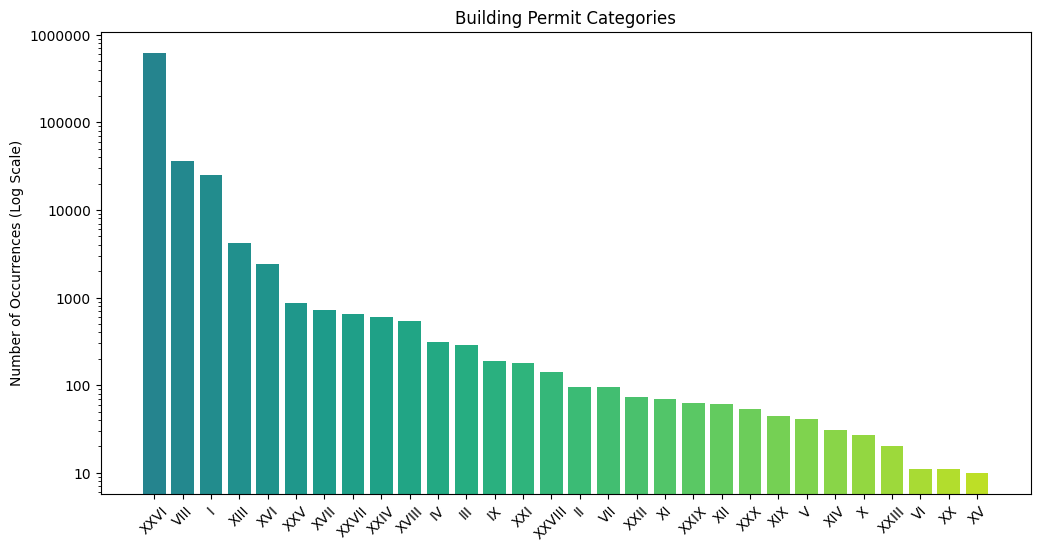

In [5]:
def categories_counter_log(df):
    counter = Counter()
    
    for record in df['kategoria']:
        counter[record] += 1

    # Sorting the data
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create color gradient for the plot
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Plot details
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45)
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Building Permit Categories')
    
    # Set Y-axis to logarithmic scale
    plt.yscale('log')

    # Format Y-axis labels as actual numbers instead of powers of 10
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

categories_counter_log(df)


### Names of construction intention type

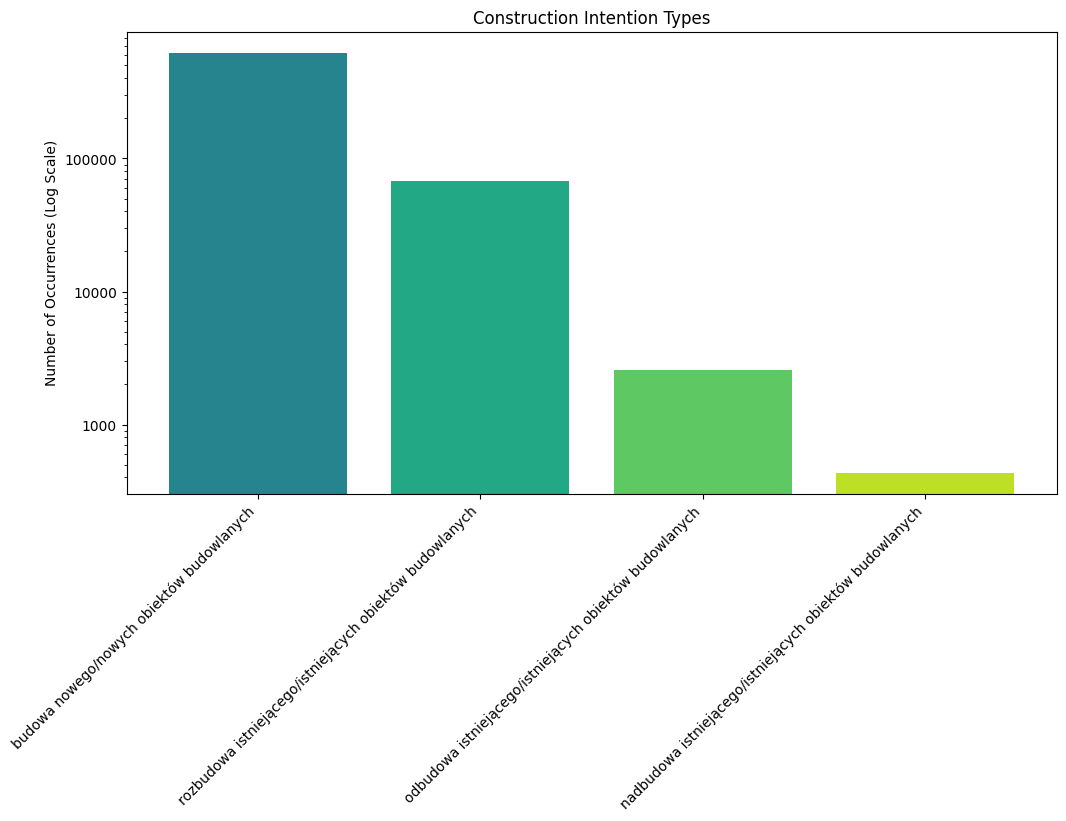

In [6]:
def construction_intention_counter_log(df, column_name):
    counter = Counter()
    
    for record in df[column_name]:
        counter[record] += 1
        
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Adjust np.linspace to match the number of categories in sorted_data
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')  
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Construction Intention Types')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

    plt.show()

construction_intention_counter_log(df, 'rodzaj_zam_budowlanego')


### Date of receipt of the build application (by month)

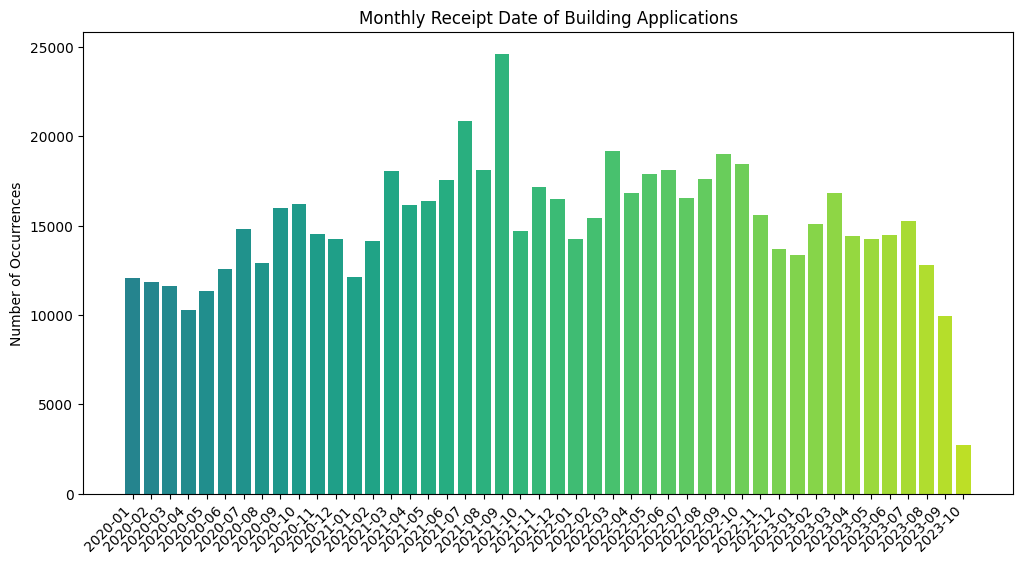

In [42]:
def monthly_receipt_date_counter(df, column_name):
    # Convert column to datetime
    df[column_name] = pd.to_datetime(df[column_name])

    # Group by year and month
    df['YearMonth'] = df[column_name].dt.to_period('M')

    # Count occurrences by month
    counter = Counter(df['YearMonth'])

    # Sort data by date (YearMonth) instead of occurrences
    sorted_data = dict(sorted(counter.items()))

    # Create the plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Convert PeriodIndex to string for plotting
    sorted_keys = [str(key) for key in sorted_data.keys()]
    plt.bar(sorted_keys, sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Occurrences')
    plt.title('Monthly Receipt Date of Building Applications')

    plt.show()

monthly_receipt_date_counter(df, 'data_wplywu_wniosku_do_urzedu')

### Teritorial units downloading

In [ ]:
url = 'https://www.gis-support.pl/downloads/2022/powiaty.zip'
local_zip_path = 'zip_data.zip'
extract_to_folder = 'unpacked_zip_data_files'
shapefile_path = 'unpacked_zip_data_files/powiaty.shp'

def download_and_unpack_zip(url, local_zip_path, extract_to_folder):
    # Start downloading the ZIP file
    print("Starting to download the ZIP file...")
    response = requests.get(url)
    
    # Save the downloaded ZIP file locally
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)
    
    # ZIP file downloaded, start extracting it
    print("ZIP file downloaded. Starting the extraction...")
    
    # Check if the extract_to_folder already exists
    if os.path.exists(extract_to_folder):
        print(f"Removing existing folder: {extract_to_folder}")
        shutil.rmtree(extract_to_folder)
    
    # Create the folder before extraction
    os.makedirs(extract_to_folder)
    
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
    
    # Extraction completed
    print("Extraction finished.")
    
    # Remove the downloaded ZIP file from the working directory
    os.remove(local_zip_path)

download_and_unpack_zip(url, local_zip_path, extract_to_folder)

gdf = gpd.read_file(shapefile_path)

### Displaying a sample of downloaded teritorial units data

In [17]:
pd.set_option('display.max_columns', None)
gdf.head()

,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,JPT_NAZWA_,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,WAZNY_DO,JPT_KOD__1,JPT_NAZWA1,JPT_ORGAN1,JPT_WAZNA_,ID_BUFORA_,ID_BUFORA1,ID_TECHNIC,IIP_PRZEST,IIP_IDENTY,IIP_WERSJA,JPT_KJ_IIP,JPT_KJ_I_1,JPT_KJ_I_2,JPT_OPIS,JPT_SPS_KO,ID_BUFOR_1,JPT_ID,JPT_POWI_1,JPT_KJ_I_3,JPT_GEOMET,JPT_GEOM_1,SHAPE_LENG,SHAPE_AREA,REGON,RODZAJ,geometry
0,None,POW,92617,1807,powiat krośnieński,None,13415,20210128,0,20170101,0,None,None,NZN,BRK,201859,0,1331302,PL.PZGIK.200,798ef296-2055-4890-993f-d414c67164ab,2021-01-28T13:43:40+01:00,EGIB,1807,None,None,UZG,0,1359583,0,None,0,0,3.11205337354,.12332626559,37044051900000,powiat,"POLYGON ((689863.285 218885.536, 689862.128 21..."
1,None,POW,141297,2804,powiat elbląski,None,13422,20210514,0,20120926,0,None,None,NZN,NZN,218263,0,829271,PL.PZGIK.200,61a0d267-58aa-4f3a-86e7-faa281e50ebc,2021-05-14T13:19:46+02:00,EGIB,2804,None,None,UZG,0,1360107,0,None,0,0,4.2521309989,.19417975633,17074769000000,powiat,"POLYGON ((551842.165 693417.652, 551870.912 69..."
2,None,POW,209827,1415,powiat ostrołęcki,None,13409,20210518,0,20120926,0,None,None,NZN,NZN,219096,0,829100,PL.PZGIK.200,d2f96418-0366-4f59-8793-fef1aa0ca19f,2021-05-18T08:56:02+02:00,EGIB,1415,None,None,UZG,0,1360143,0,None,0,0,5.31641009622,.28125317026,55066883500000,powiat,"POLYGON ((646230.458 617154.258, 646336.602 61..."
3,None,POW,79097,0413,powiat sępoleński,None,13424,20220112,0,20120926,0,None,None,NZN,NZN,253504,0,829353,PL.PZGIK.200,09447bc4-a3c3-4d84-83ab-d61a69820974,2022-01-12T10:03:23+01:00,EGIB,0413,None,None,UZG,0,1362180,0,None,0,0,2.00313300009,.10690160786,09235092600000,powiat,"POLYGON ((384997.245 615178.269, 385170.687 61..."
4,None,POW,126576,3019,powiat pilski,None,13417,20220112,0,20120926,0,None,None,NZN,NZN,253504,0,829157,PL.PZGIK.200,196c6cd5-4f8d-4e98-a653-e0a36ccac728,2022-01-12T10:03:23+01:00,EGIB,3019,None,None,UZG,0,1362184,0,None,0,0,4.17134504707,.17008216429,57079948000000,powiat,"POLYGON ((342585.530 579834.380, 342632.859 57..."


### Applying voivodships and powiats' names to records of build permits data

In [36]:
# Dictionary with mappings of voivodeship codes to voivodeship names
voivodeships = {
    '02': 'Lower Silesian',
    '04': 'Kuyavian-Pomeranian',
    '06': 'Lublin',
    '08': 'Lubusz',
    '10': 'Lodz',
    '12': 'Lower Poland',
    '14': 'Masovian',
    '16': 'Opole',
    '18': 'Podkarpackie',
    '20': 'Podlaskie',
    '22': 'Pomeranian',
    '24': 'Silesian',
    '26': 'Swietokrzyskie',
    '28': 'Warmian-Masurian',
    '30': 'Greater Poland',
    '32': 'West Pomeranian',
}

bad_voivod_temp_iter = 0
good_voivod_temp_iter = 0
bad_powiat_temp_iter = 0
good_powiat_temp_iter = 0

# Function for assigning voivodeship names based on TERYT code
def terc_to_voivodeship(terc_code):
    global bad_voivod_temp_iter
    global good_voivod_temp_iter
    voivodeship_code = terc_code[:2]
    
    # Check if the voivodeship code exists in the dictionary
    if voivodeship_code in voivodeships:
        voivodeship = voivodeships[voivodeship_code]
        good_voivod_temp_iter = good_voivod_temp_iter+1
    else:
        voivodeship = 'Unknown'
        bad_voivod_temp_iter = bad_voivod_temp_iter+1
        #print(f"ERROR for Voivodship: {terc_code}") #if needed, it can be uncommeneted to check what the incorrect codes are
    
    return voivodeship

# Create a nested dictionary to map powiat codes to powiat names
powiat_mapping = {}

for index, row in gdf.iterrows():
    kod_je = row['JPT_KOD_JE']
    nazwa = row['JPT_NAZWA_']
    
    # Extract the first two digits as the outer key and the next two digits as the inner key
    outer_key = kod_je[:2]
    inner_key = kod_je[2:]
    
    # Initialize the outer dictionary if it doesn't exist
    if outer_key not in powiat_mapping:
        powiat_mapping[outer_key] = {}
    
    # Assign the value in the nested dictionary
    powiat_mapping[outer_key][inner_key] = nazwa
    

def terc_to_powiat(terc_code):
    global bad_powiat_temp_iter
    global good_powiat_temp_iter
    voivodship_code = terc_code[0:2]
    powiat_code = terc_code[2:4]
    
    # Initialize the powiat variable with "Unknown" as a default
    powiat = 'Unknown'
    
    # Check if the voivodship_code exists in powiat_mapping
    if voivodship_code in powiat_mapping:
        # Check if the powiat_code exists in the voivodship's dictionary
        if powiat_code in powiat_mapping[voivodship_code]:
            powiat = powiat_mapping[voivodship_code][powiat_code]
            good_powiat_temp_iter = good_powiat_temp_iter + 1
        else:
            bad_powiat_temp_iter = bad_powiat_temp_iter + 1
            #print(f"ERROR for POWIAT: {terc_code}") #if needed, it can be uncommeneted to check what the incorrect codes are
    else:
        bad_powiat_temp_iter = bad_powiat_temp_iter + 1
        #print(f"ERROR for POWIAT: {terc_code}") #if needed, it can be uncommeneted to check what the incorrect codes are
        
    return powiat

def assign_terc(row):
    terc_code = row['terc']
    if not terc_code:  #If terc code is empty
        miasto = row['miasto']

        matching_rows = gdf[gdf['JPT_NAZWA_'].str.contains(miasto, case=False, na=False)]
        
        if not matching_rows.empty:
            matching_row = matching_rows.iloc[0]
            terc_code = matching_row['JPT_KOD_JE']
        else:
            terc_code = 'Unknown'
            
    voivodeship = terc_to_voivodeship(terc_code)
    powiat = terc_to_powiat(terc_code)
    
    return pd.Series({'terc': terc_code, 'voivodeship': voivodeship, 'powiat': powiat})

# Zastosuj funkcję do DataFrame df
df[['terc', 'voivodeship', 'powiat']] = df.apply(assign_terc, axis=1)

print(f"Numer of incorrect voivodship records (after validation): {bad_voivod_temp_iter}")
print(f"Number of correct voivodship records (after validation): {good_voivod_temp_iter}")
print(f"Number of incorrect powiat records (after validation): {bad_powiat_temp_iter}")
print(f"Number of correct powiat records (after validation): {good_powiat_temp_iter}")

Numer of incorrect voivodship records (after validation): 25
Number of correct voivodship records (after validation): 696168
Number of incorrect powiat records (after validation): 29
Number of correct powiat records (after validation): 696164


### Plots with building application per voivodship from last 3,2 and 1 month

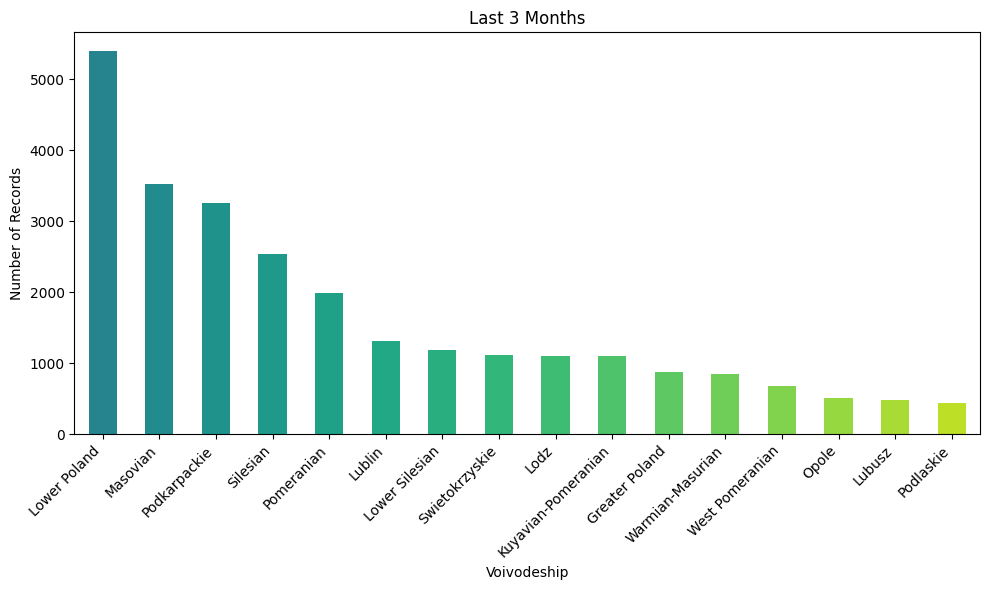

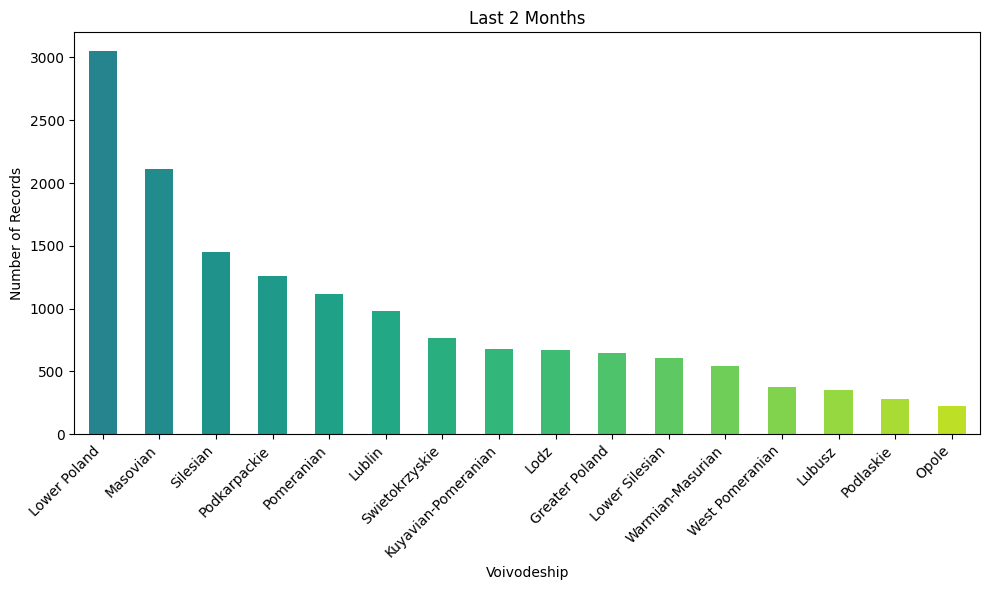

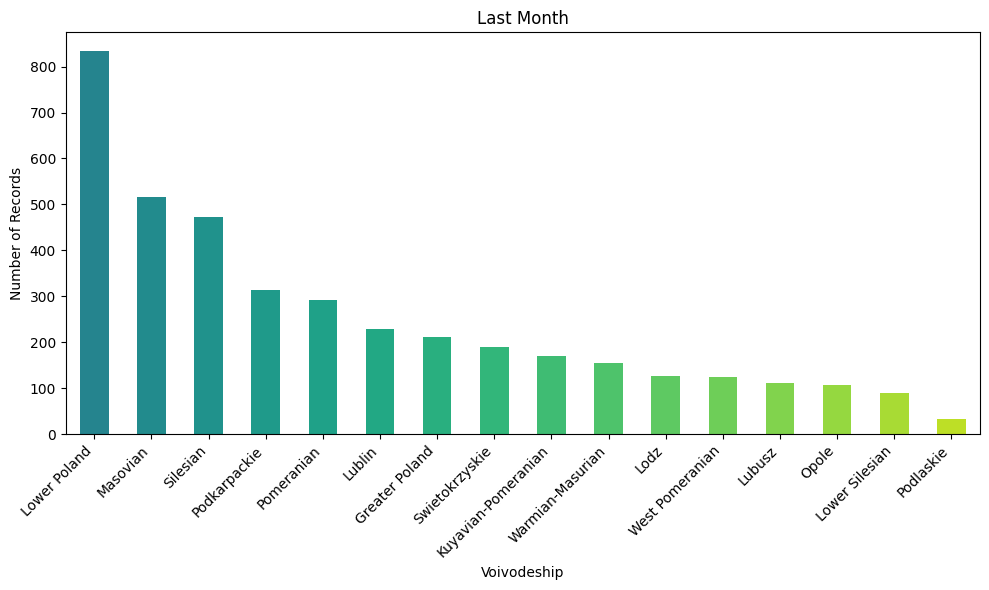

In [40]:
# Convert the 'data_wplywu_wniosku_do_urzedu' column to datetime objects
df['data_wplywu_wniosku_do_urzedu'] = pd.to_datetime(df['data_wplywu_wniosku_do_urzedu'])

# Define the end date (latest date in the data)
end_date = df['data_wplywu_wniosku_do_urzedu'].max()

# Calculate the start dates for three time periods (3 months, 2 months, 1 month)
three_months_ago = end_date - timedelta(days=90)
two_months_ago = end_date - timedelta(days=60)
one_month_ago = end_date - timedelta(days=30)

# Filter the data for each time period
df_three_months = df[df['data_wplywu_wniosku_do_urzedu'] >= three_months_ago]
df_two_months = df[df['data_wplywu_wniosku_do_urzedu'] >= two_months_ago]
df_one_month = df[df['data_wplywu_wniosku_do_urzedu'] >= one_month_ago]

# Generate plots with the same colors and axis labels as the specified plot
def generate_plot(data, title):
    data = data[data['voivodeship'] != 'Unknown']  # Remove records with 'Unknown' in the 'voivodeship' column
    voivodeship_counts = data['voivodeship'].value_counts()

    # Use viridis color palette
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(voivodeship_counts)))

    plt.figure(figsize=(10, 6))
    voivodeship_counts.plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel('Voivodeship')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

generate_plot(df_three_months, 'Last 3 Months')
generate_plot(df_two_months, 'Last 2 Months')
generate_plot(df_one_month, 'Last Month')


### Plots with building application per example voivodship of Lower Poland per powiat from last 3,2 and 1 month

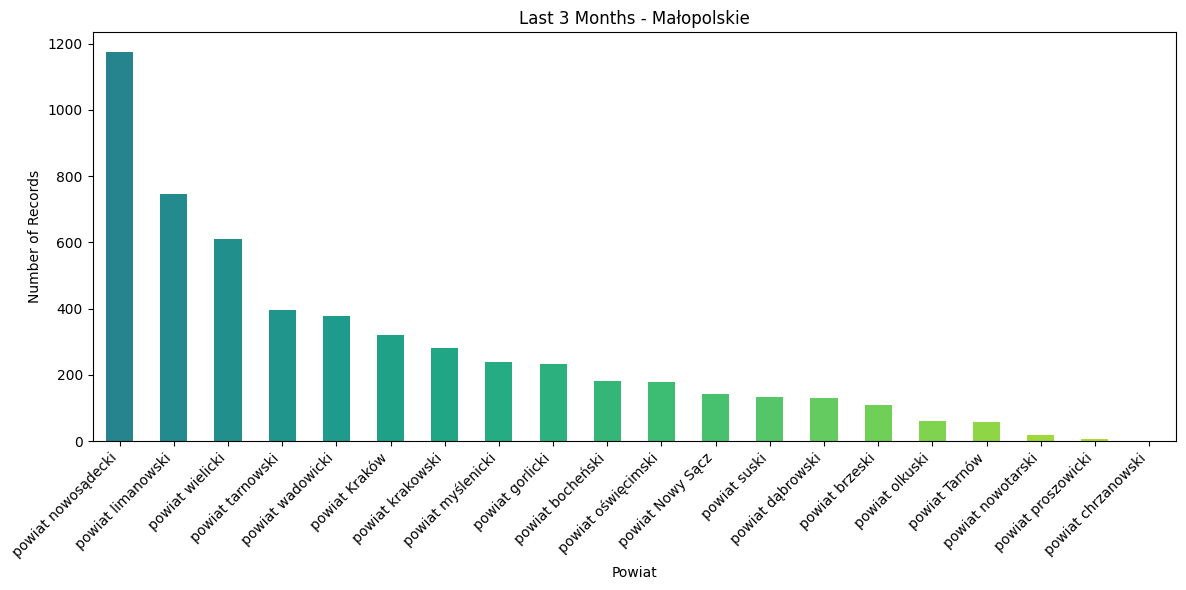

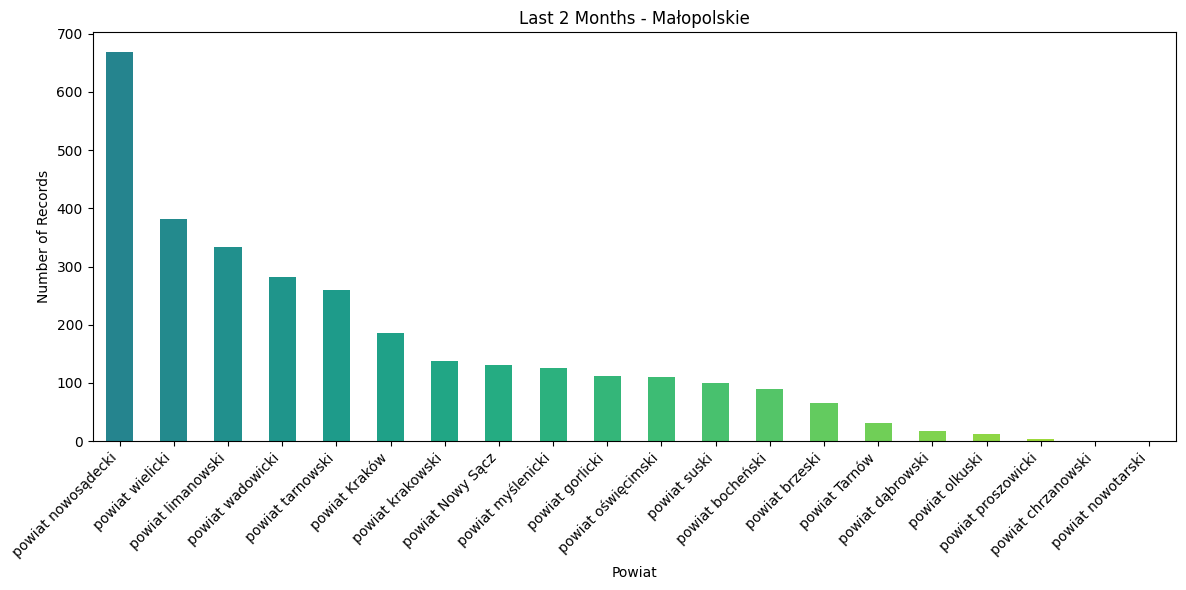

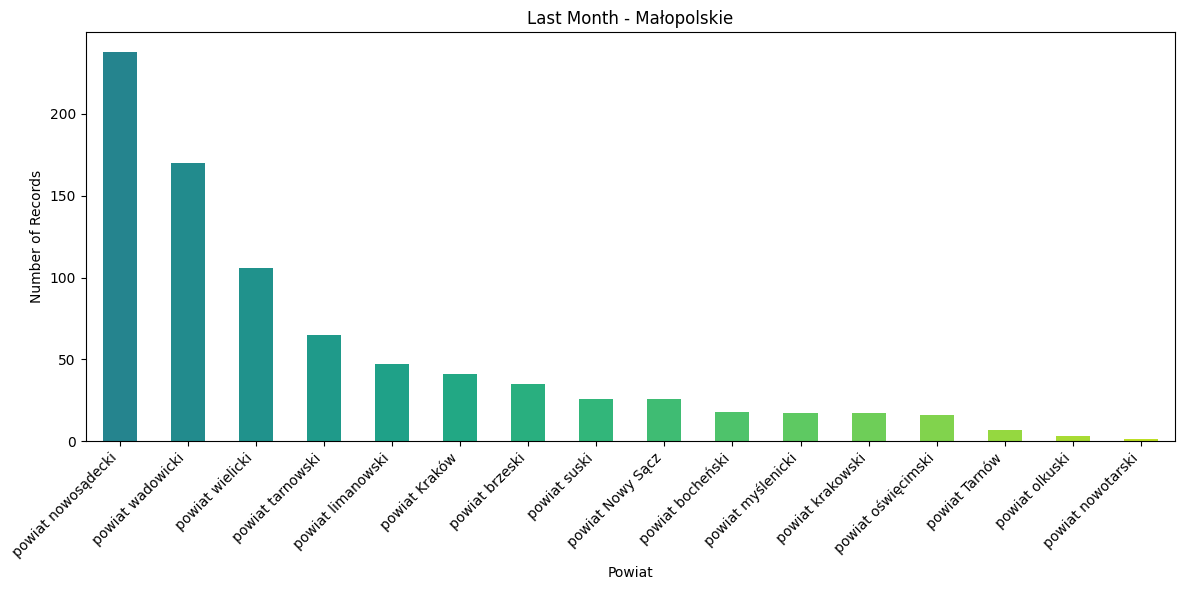

In [45]:
# Convert the 'data_wplywu_wniosku_do_urzedu' column to datetime objects
df['data_wplywu_wniosku_do_urzedu'] = pd.to_datetime(df['data_wplywu_wniosku_do_urzedu'])

# Define the end date (latest date in the data)
end_date = df['data_wplywu_wniosku_do_urzedu'].max()

# Calculate the start dates for three time periods (3 months, 2 months, 1 month)
three_months_ago = end_date - timedelta(days=90)
two_months_ago = end_date - timedelta(days=60)
one_month_ago = end_date - timedelta(days=30)

# Filter the data for each time period
df_three_months = df[df['data_wplywu_wniosku_do_urzedu'] >= three_months_ago]
df_two_months = df[df['data_wplywu_wniosku_do_urzedu'] >= two_months_ago]
df_one_month = df[df['data_wplywu_wniosku_do_urzedu'] >= one_month_ago]

# Generate plots for Małopolskie voivodeship with county breakdown
def generate_plot_with_counties(data, title, voivodeship_name='Lower Poland'):
    # Filter data for Małopolskie voivodeship
    małopolskie_data = data[data['voivodeship'] == voivodeship_name]
    
    # Remove records with 'Unknown' in the 'powiat' column
    małopolskie_data = małopolskie_data[małopolskie_data['powiat'] != 'Unknown']
    
    # Count occurrences of each powiat
    powiat_counts = małopolskie_data['powiat'].value_counts()
    
    # Determine the number of unique powiats and the corresponding number of colors
    num_unique_powiats = len(powiat_counts)
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, num_unique_powiats))

    plt.figure(figsize=(12, 6))
    powiat_counts.plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel('Powiat')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

generate_plot_with_counties(df_three_months, 'Last 3 Months - Lower Poland')
generate_plot_with_counties(df_two_months, 'Last 2 Months - Lower Poland')
generate_plot_with_counties(df_one_month, 'Last Month - Lower Poland')
